# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

<div class="span5 alert alert-info">
### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution
</div>
****

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
from scipy.stats import norm

In [5]:
data = pd.io.stata.read_stata('data_racial_discrimination/us_job_market_discrimination.dta')

In [6]:
# number of callbacks for black-sounding names
sum(data[data.race=='w'].call)

235.0

In [7]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


<div class="span5 alert alert-success">
<p>Your answers to Q1 and Q2 here</p>
</div>

1. What test is appropriate for this problem? Does CLT apply?
2. What are the null and alternate hypotheses?

In [8]:
# null hypothesis - name assignment makes no difference (p_black = p_white)
# alternative hypothesis - name assignment makes a difference (p_black != p_white)
# two sample test for difference of means (i can try bootstrap as well as frequentist approach)
# clt does apply. to do to the two sample test, i need the t-statistic to calculate the p-value

In [9]:
w = data[data.race=='w']
b = data[data.race=='b']

   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.

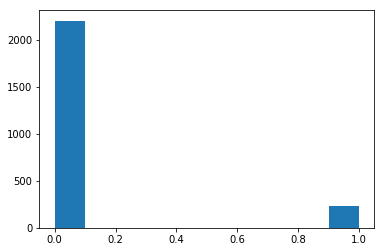

In [10]:
_ = plt.hist(w.call)
plt.show()

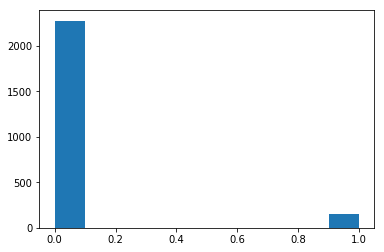

In [11]:
_ = plt.hist(b.call)
plt.show()

In [12]:
# check assumptions
n_w = len(w.call)
p_w = np.mean(w.call)

n_b = len(b.call)
p_b = np.mean(b.call)

n_w * p_w
n_w * (1 - p_w)

n_b * p_b
n_b * (1 - p_b)

2278.0000007897615

In [13]:
# frequentist approach
# useful site: https://onlinecourses.science.psu.edu/stat500/node/55/
# assume normal distribution of means
empirical_diff_proportions = np.mean(w.call) - np.mean(b.call)

p_overall = np.mean(data.call)

# assuming unequal variance
sample_se = np.sqrt(p_w * (1 - p_w) / n_w + p_b * (1 - p_b) / n_b)

# test statistic
z = empirical_diff_proportions / sample_se

norm.sf(z) * 2 # conclusion = very different. low p-value

3.86256381290969e-05

In [14]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))
def draw_bs_reps(data, func, size=1):
    return np.array([bootstrap_replicate_1d(data, func) for _ in range(size)])

In [15]:
# bootstrap test of proportions

# Compute mean of all forces: proportion_call
proportion_call = np.mean(data.call)

# Generate shifted arrays
w.call_shifted = w.call - np.mean(w.call) + proportion_call
b.call_shifted = b.call - np.mean(b.call) + proportion_call

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(w.call_shifted, np.mean, 10000)
bs_replicates_b = draw_bs_reps(b.call_shifted, np.mean, 10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_a - bs_replicates_b

# Compute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_proportions) / 10000
print('p-value =', p)

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


p-value = 0.0001


/root/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


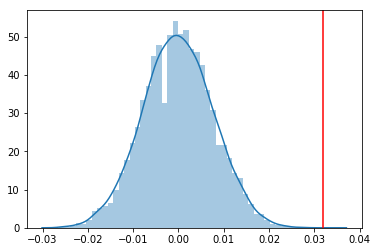

In [16]:
_ = sns.distplot(bs_replicates)
_ = plt.axvline(x=empirical_diff_proportions, color = 'red')
plt.show()

In [17]:
# same distribution? permutation test
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

def permutation_sample(data_1, data_2):
    permuted_data = np.random.permutation(np.concatenate((data_1, data_2)))
    return permuted_data[:len(data_1)], permuted_data[len(data_1):]

def draw_perm_reps(d1, d2, func, size=1):
    return np.array([func(*permutation_sample(d1, d2)) for i in range(size)])


# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(w.call, b.call,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_proportions) / len(perm_replicates)

# Print the result
print('p-value =', p)


p-value = 0.0


/root/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


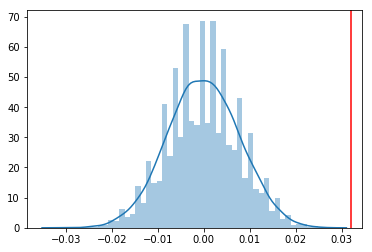

In [18]:
_ = sns.distplot(perm_replicates)
_ = plt.axvline(x=empirical_diff_proportions, color = 'red')
plt.show()

In [19]:
# confidence intervals
# frequentist approach
empirical_diff_proportions + 1.96 * np.array([-sample_se, sample_se]) # doesn't include zero so different

array([0.01677745, 0.04728826])

95% confidence interval = [0.08459959 0.10841889] games


/root/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


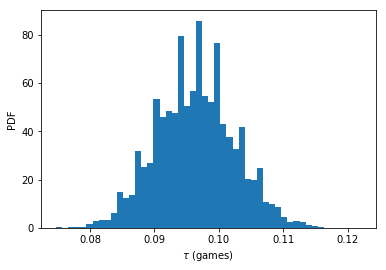

In [20]:
# Draw bootstrap replicates of the mean no-hitter time (equal to tau): bs_replicates
bs_replicates = draw_bs_reps(w.call, np.mean, 10000)

# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates, q = [2.5, 97.5])

# Print the confidence interval
print('95% confidence interval =', conf_int, 'games')

# Plot the histogram of the replicates
_ = plt.hist(bs_replicates, bins=50, normed=True)
_ = plt.xlabel(r'$\tau$ (games)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

95% confidence interval = [0.0550308  0.07434291] games


/root/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


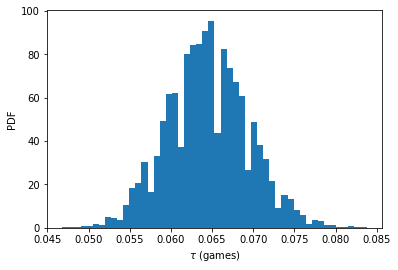

In [21]:
# Draw bootstrap replicates of the mean no-hitter time (equal to tau): bs_replicates
bs_replicates = draw_bs_reps(b.call, np.mean, 10000)

# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates, q = [2.5, 97.5])

# Print the confidence interval
print('95% confidence interval =', conf_int, 'games')

# Plot the histogram of the replicates
_ = plt.hist(bs_replicates, bins=50, normed=True)
_ = plt.xlabel(r'$\tau$ (games)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

In [22]:
# two confidence intervals dont overlap

<div class="span5 alert alert-success">
<p> Your answers to Q4 and Q5 here </p>
</div>

4. Write a story describing the statistical significance in the context or the original problem.
5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

statistically significant. but not the most important factor as there are still other factors involved. like education level and experience level. im not sure how to tweak the experiment to see if this is the most important factor.